<a href="https://aicafe.one/" target="_blank"><img alt="AI Cafe¹" src="https://edu.aicafe.one/logo.png" height="48" style="height: 48px"></a><br/>
© Bản quyền thuộc về Quantopian Inc.<br/>
© Bản quyền sửa đổi thuộc về AI Cafe¹<br/>
Giấy phép [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).<br>
<a href="https://aicafe.one/khuyen-cao/">Khuyến cáo</a>

<a href="https://colab.research.google.com/drive/1Qn4BqljtJvpPrF-WCsNUc8YoUl-nff0u" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
---

# Tại Sao Nên Phòng vệ Beta và Rủi Ro Ngành

by Jonathan Larkin and Maxwell Margenot

Edited by AI Cafe¹

Bất cứ khi nào chúng ta có một chiến lược giao dịch nào đó, chúng ta cần phải xem xét tác động của rủi ro hệ thống. Cần có một số rủi ro liên quan đến một chiến lược để có được lợi suất cao hơn lãi suất phi rủi ro, nhưng rủi ro hệ thống làm hỏng mọi thứ, có thể nói như vậy. Bản chất của rủi ro hệ thống tạo ra một sự chung giữa nhiều chứng khoán trên thị trường mà không thể đa dạng hóa. Do đó, chúng ta cần xây dựng một biện pháp bảo hiểm để loại bỏ nó.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
import seaborn as sns
import statsmodels.api as sm

## Luật Cơ Bản của Quản Lý Tài Sản

Yếu tố chính thúc đẩy giá trị của bất kỳ chiến lược nào là liệu nó có cung cấp lợi suất điều chỉnh theo rủi ro hấp dẫn hay không, tức là tỷ lệ Sharpe. Như được diễn đạt trong "Luật Cơ Bản của Quản Lý Chủ Động" của Richard Grinold, tỷ lệ Sharpe có thể được phân tích thành hai thành phần, kỹ năng và độ rộng, như sau:

$$IR = IC \sqrt{BR}$$

Kỹ thuật mà nói, đây là định nghĩa của Tỷ lệ Thông tin (IR), nhưng cho mục đích của chúng ta, nó tương đương với tỷ lệ Sharpe. IR là tỷ lệ của lợi suất vượt trội của một danh mục đầu tư so với chỉ số tham chiếu trên mỗi đơn vị rủi ro chủ động, tức là lợi suất vượt trội của một danh mục đầu tư chỉ mua dài trừ đi chỉ số tham chiếu trên mỗi đơn vị sai số theo dõi. Tuy nhiên, vào thời điểm Grinold công bố, việc đầu tư Long/Short là một điều hiếm gặp. Ngày nay, trong thế giới quỹ đầu tư phòng hộ và đầu tư Long/Short, không có chỉ số tham chiếu. Chúng ta tìm kiếm lợi suất tuyệt đối, vì vậy, trong trường hợp này, IR tương đương với tỷ lệ Sharpe.

Trong phương trình này, kỹ năng được đo bằng IC (Hệ số Thông tin), được tính toán bằng Alphalens. IC về cơ bản là hệ số tương quan thứ hạng Spearman, được sử dụng để tương quan giữa dự đoán của bạn và sự hiện thực hóa của nó. Độ rộng được đo bằng số lượng **cược độc lập** trong khoảng thời gian đó. Bài học rút ra từ "luật" này là, với bất kỳ chiến lược nào, chúng ta cần phải:

1. Cược tốt (IC cao),
2. Cược thường xuyên (số lượng cược cao), *và*
3. **Cược độc lập**

Nếu các lần cược hoàn toàn độc lập, thì độ rộng là tổng số cược mà chúng ta đã thực hiện cho mỗi tài sản đơn lẻ, số lượng tài sản nhân với số kỳ. Nếu các cược không độc lập thì **độ rộng hiệu quả** có thể nhỏ hơn rất nhiều so với số lượng tài sản. Hãy xem chính xác việc tiếp xúc beta và tiếp xúc ngành ảnh hưởng như thế nào đến **độ rộng hiệu quả**.

<div class="alert alert-warning">
<b>Tóm tắt:</b> Sự tiếp xúc với beta và sự tiếp xúc với ngành dẫn đến một sự gia tăng đáng kể trong mối tương quan giữa các lần cược. Các danh mục đầu tư có cược beta và cược ngành có độ rộng hiệu quả rất thấp. Để có được Sharpe cao, các danh mục đầu tư này phải có IC rất cao. Việc tăng độ rộng hiệu quả bằng cách phòng ngừa sự tiếp xúc với beta và ngành dễ hơn so với việc tăng IC của bạn.
</div>

## Dự Đoán và Tương Quan Đặt Cược

Chúng ta định nghĩa một cược là dự đoán về *phần dư* của lợi nhuận một chứng khoán. Dự đoán này có thể là ngầm hiểu - tức là, chúng ta mua một cổ phiếu và do đó ngầm hiểu rằng cổ phiếu đó sẽ tăng giá. Nhưng chúng ta hiểu gì về *phần dư*? Không cần toán học phức tạp, điều này đơn giản có nghĩa là lợi nhuận **trừ đi một khoản bảo hiểm**. Hãy cùng xem qua ba ví dụ. Chúng ta sử dụng ước lượng hiệp phương sai Ledoit-Wolf để đánh giá hiệp phương sai trong tất cả các trường hợp. Để biết thêm thông tin về lý do tại sao chúng ta sử dụng Ledoit-Wolf thay vì hiệp phương sai mẫu thông thường, hãy xem bài giảng về Ước Lượng Ma Trận Hiệp Phương Sai.

### Ví Dụ 1: Không Có Bảo Hiểm!

Nếu chúng ta đầu tư vào một tập hợp chứng khoán, nhưng không giữ bất kỳ vị thế bán khống nào, thì không có khoản bảo hiểm nào! Vì vậy, *phần dư* chính là lợi nhuận của cổ phiếu đó.

$$r_{resid,i} = r_i$$

Hãy xem tương quan của các cược của chúng ta trong trường hợp này.

In [ ]:
# Cài thư viện lấy dữ liệu miễn phí
!curl -fsSLO https://raw.githubusercontent.com/algo-stocks/data/master/data.py

In [ ]:
from data import get_prices

start = '2024-01-01'
end = '2025-01-01'

tickers = ['BID', 'CTG', 'ACB', 'HDG', 'VIC', 'VRE']
historical_prices = get_prices(*tickers, start_date=start, end_date=end).ffill()

rets = historical_prices.pct_change().fillna(0) # Calculate returns
lw_cov = LedoitWolf().fit(rets).covariance_ # Calculate Ledoit-Wolf estimator

def extract_corr_from_cov(cov_matrix):
    # Linear algebra result:
    # https://math.stackexchange.com/questions/186959/correlation-matrix-from-covariance-matrix
    d = np.linalg.inv(np.diag(np.sqrt(np.diag(cov_matrix))))
    corr = d.dot(cov_matrix).dot(d)
    return corr

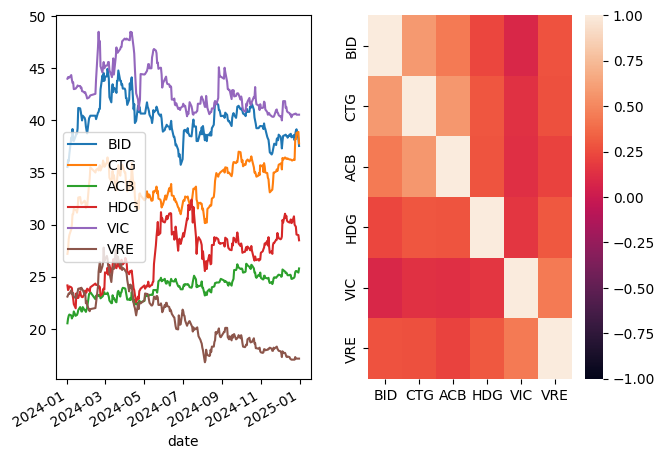

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()

corr = extract_corr_from_cov(lw_cov)
# Plot prices
left = historical_prices.plot(ax=ax1)
# Plot covariance as a heat map
right = sns.heatmap(corr, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=tickers, yticklabels=tickers)

In [ ]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print('Average pairwise correlation: %.4f' % average_corr)

Average pairwise correlation: 0.2938


Kết quả ở đây là chúng ta có sáu lần cược và tất cả đều có sự tương quan rất cao.

### Ví dụ 2: Bảo hiểm Beta

Trong trường hợp này, chúng ta sẽ giả định rằng mỗi cược được bảo hiểm chống lại thị trường (VNINDEX). Trong trường hợp này, phần dư được tính toán như sau:

$$ r_{resid,i} = r_i - \beta_i r_i $$

trong đó $\beta_i$ là beta của tài sản $i$ so với thị trường được tính toán bằng CAPM và $r_i$ là lợi nhuận của tài sản $i$.

In [ ]:
tickers = ['BID', 'CTG', 'ACB', 'HDG', 'VIC', 'VRE', 'VNINDEX']
historical_prices = get_prices(*tickers, start_date=start, end_date=end).ffill()

rets = historical_prices.pct_change().fillna(0) # Calculate returns

market = rets['VNINDEX']
stock_rets = rets.drop('VNINDEX', axis=1)
residuals = stock_rets.copy()*0

for stock in stock_rets.columns:
    model = sm.OLS(stock_rets[stock], market.values)
    results = model.fit()
    residuals[stock] = results.resid

lw_cov = LedoitWolf().fit(residuals).covariance_ # Calculate Ledoit-Wolf Estimator

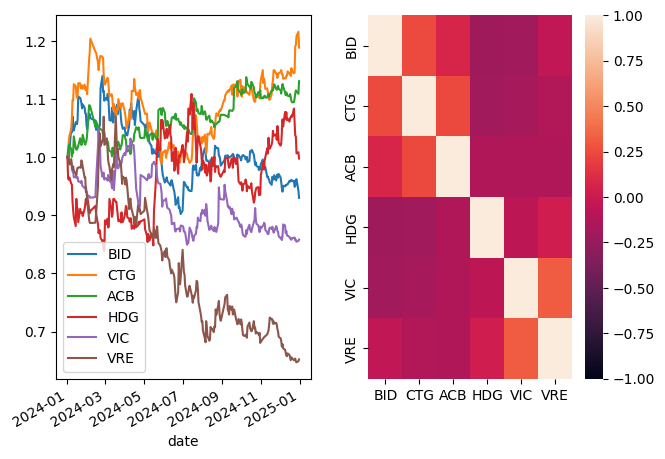

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()

corr = extract_corr_from_cov(lw_cov)
left = (1+residuals).cumprod().plot(ax=ax1)
right = sns.heatmap(corr, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=stock_rets.columns, yticklabels=stock_rets.columns)

In [ ]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print('Average pairwise correlation: %.4f' % average_corr)

Average pairwise correlation: -0.0351


Hedging beta đã giảm đáng kể mối tương quan trung bình. Về lý thuyết, điều này nên cải thiện độ rộng của chúng ta. Rõ ràng là chúng ta vẫn còn hai cụm có mối tương quan cao. Hãy xem điều gì sẽ xảy ra khi chúng ta phòng ngừa rủi ro theo ngành.

### Ví dụ 3: Bảo hiểm Ngành

Lợi nhuận của ngành và lợi nhuận của thị trường có mối tương quan cao với nhau. Do đó, bạn không thể thực hiện hồi quy đa biến do hiện tượng đa cộng tuyến, một vi phạm cổ điển của các giả định hồi quy (xem bài giảng "Vi phạm Mô hình Hồi quy"). Để bảo hiểm chống lại cả thị trường và một ngành cụ thể của chứng khoán, trước tiên bạn ước lượng các dư thừa beta thị trường và sau đó tính toán beta ngành trên *các* dư thừa đó.

$$
r_{resid,i} = r_i - \beta_i r_i \\
r_{resid_{SECTOR},i}= r_{resid,i} - \beta_{SECTOR,i}r_{resid,i}
$$

Ở đây, $r_{resid, i}$ là dư thừa giữa lợi nhuận của chứng khoán và một bảo hiểm beta thị trường, và $r_{resid_{SECTOR}, i}$ là dư thừa giữa *dư thừa đó* và một bảo hiểm của dư thừa đó chống lại ngành liên quan.

In [ ]:
tickers = ['BID', 'CTG', 'ACB', 'HDG', 'VIC', 'VRE', 'VNINDEX', 'VCB', 'VHM']

# Obtain prices
historical_prices = get_prices(*tickers, start_date=start, end_date=end).ffill()

rets = historical_prices.pct_change().fillna(0) # Calculate returns

# Get market hedge ticker
mkt = 'VNINDEX'
# Get sector hedge tickers
sector_1_hedge = 'VCB'
sector_2_hedge = 'VHM'
# Identify securities for each sector
sector_1_stocks = ['BID', 'CTG', 'ACB']
sector_2_stocks = ['HDG', 'VIC', 'VRE']

market_rets = rets[mkt]
sector_1_rets = rets[sector_1_hedge]
sector_2_rets = rets[sector_2_hedge]

stock_rets = rets.drop(['VNINDEX', 'VCB', 'VHM'], axis=1)
residuals_market = stock_rets.copy()*0
residuals = stock_rets.copy()*0
# Calculate market beta of sector 1 benchmark
model = sm.OLS(sector_1_rets.values, market.values)
results = model.fit()
sector_1_excess = results.resid
# Calculate market beta of sector 2 benchmark
model = sm.OLS(sector_2_rets.values, market.values)
results = model.fit()
sector_2_excess = results.resid

for stock in sector_1_stocks:
    # Calculate market betas for sector 1 stocks
    model = sm.OLS(stock_rets[stock], market.values)
    results = model.fit()
    # Calculate residual of security + market hedge
    residuals_market[stock] = results.resid
    # Calculate sector beta for previous residuals
    model = sm.OLS(residuals_market[stock], sector_1_excess)
    results = model.fit()
    # Get final residual
    residuals[stock] = results.resid

for stock in sector_2_stocks:
    # Calculate market betas for sector 2 stocks
    model = sm.OLS(stock_rets[stock], market.values)
    results = model.fit()
    # Calculate residual of security + market hedge
    residuals_market[stock] = results.resid
    # Calculate sector beta for previous residuals
    model = sm.OLS(residuals_market[stock], sector_2_excess)
    results = model.fit()
    # Get final residual
    residuals[stock] = results.resid

# Get covariance of residuals
lw_cov = LedoitWolf().fit(residuals).covariance_

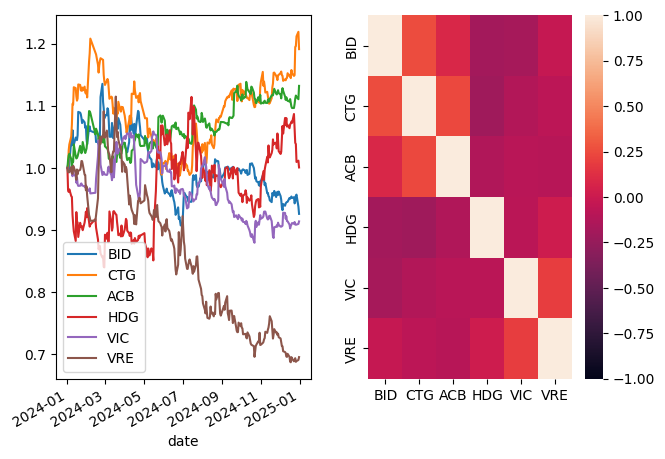

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()

corr = extract_corr_from_cov(lw_cov)
left = (1+residuals).cumprod().plot(ax=ax1)
labels = sector_1_stocks + sector_2_stocks
right = sns.heatmap(corr, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=labels, yticklabels=labels)

In [ ]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print('Average pairwise correlation: %.4f' % average_corr)

Average pairwise correlation: -0.0281


Bảo hiểm theo ngành đã làm giảm thêm mối tương quan giữa các lần cược của chúng ta.

## Tính Toán Độ Rộng Hiệu Quả

Phần này dựa trên bài viết "Cách tính độ rộng: Một sự phát triển của luật cơ bản trong quản lý danh mục đầu tư chủ động", của David Buckle; Tập 4, Số 6, trang 393-405, năm 2003, _Tạp chí Quản lý Tài sản_. Buckle rút ra "luật cơ bản bán tổng quát về quản lý chủ động" dưới một số giả định yếu. Kết quả chính của bài báo này (đối với chúng ta) là một phép tính dạng đóng của độ rộng hiệu quả như một hàm của sự tương quan giữa các lần cược. Buckle chỉ ra rằng độ rộng, $BR$, có thể được mô hình hóa như sau:

$$BR = \frac{N}{1 + \rho(N -1)}$$

Trong đó N là số lượng cổ phiếu trong danh mục đầu tư và $\rho$ là sự tương quan đơn được giả định của biến động dự kiến xung quanh dự báo.

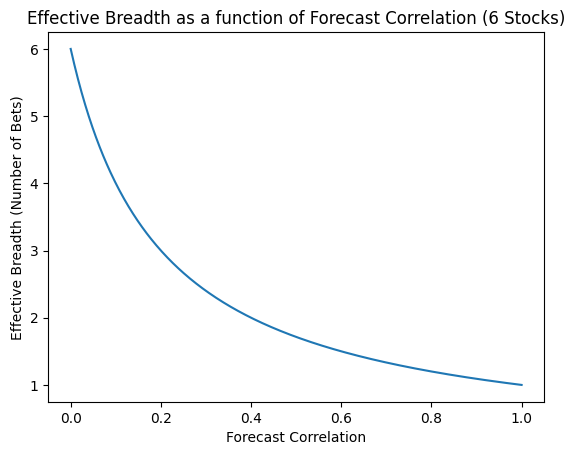

In [ ]:
def buckle_BR_const(N, rho):
    return N/(1 + rho*(N - 1))

corr = np.linspace(start=0, stop=1.0, num=500)
plt.plot(corr, buckle_BR_const(6, corr))
plt.title('Effective Breadth as a function of Forecast Correlation (6 Stocks)')
plt.ylabel('Effective Breadth (Number of Bets)')
plt.xlabel('Forecast Correlation');

Ở đây, chúng ta thấy rằng trong trường hợp của danh mục đầu tư chỉ mua Long, nơi mà hệ số tương quan trung bình là 0.29, chúng ta *thực sự chỉ đang thực hiện khoảng 2.4 lần cược*. Khi chúng ta phòng ngừa beta, chúng ta gần như đạt được hệ số tương quan bằng không, và trong trường hợp này, số lượng cược bằng với số lượng tài sản, là 6.

**Nhiều cược độc lập hơn với cùng một IC dẫn đến tỷ lệ Sharpe cao hơn.**

## Sử Dụng Điều Này Trong Thực Tế

Giao dịch tốn tiền do tác động của thị trường và hoa hồng. Do đó, việc thực hiện một biện pháp phòng ngừa sau khi đã xảy ra là gần như luôn không tối ưu. Trong trường hợp đó, bạn đang giao dịch chỉ để phòng ngừa rủi ro. Tốt hơn là nên suy nghĩ về lĩnh vực và sự tiếp xúc với thị trường *trong suốt quá trình phát triển mô hình*. Rủi ro của lĩnh vực và thị trường tự nhiên được phòng ngừa trong một chiến lược giao dịch theo cặp; trong một chiến lược cắt ngang, hãy xem xét việc loại bỏ trung bình của vector alpha bằng cách lấy trung bình theo lĩnh vực; với một chiến lược dựa trên sự kiện, hãy xem xét việc thêm các alpha bổ sung để bạn có thể tìm thấy những lần cược bù đắp trong cùng lĩnh vực. Như một biện pháp cuối cùng, hãy phòng ngừa với một quỹ ETF theo lĩnh vực được chọn lựa kỹ càng.

---
*Lưu ý: Tài liệu này mang tính chất chia sẻ kiến thức khoa học dữ liệu. Các mã chứng khoán xuất hiện trong tài liệu chỉ mang tính chất minh hoạ, không khuyến nghị đầu tư. Chúng tôi không chịu trách nhiệm trước mọi rủi ro nào do sử dụng tài liệu này.*